In [1]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
seed = 42
np.random.seed(seed)

created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

if not os.path.isdir(path_images_augmented):
    os.mkdir(path)
    
clean = True
if clean:
    print("Deleting old augmented")
    os.system(f'rm -rf {path_images_augmented}*')

nb_classes = 9
epochs = 100
batch_size = 32
monitor='val_accuracy'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = f'DenseNet121_{nb_classes}classes_{img_dim}'

Deleting old augmented


/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


nr of test plates: 21
nr of all plates: 253


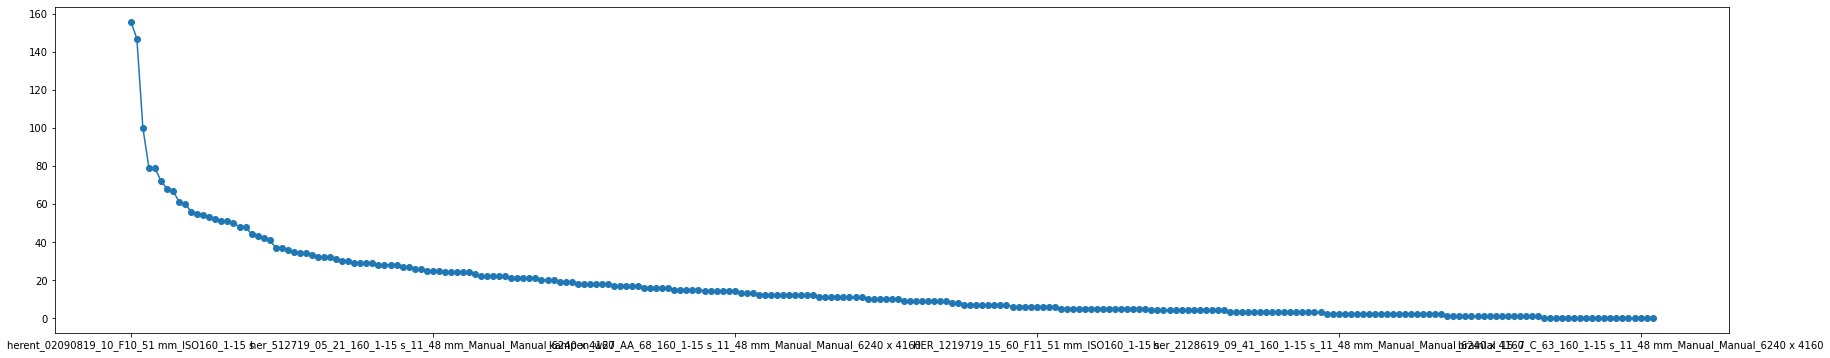

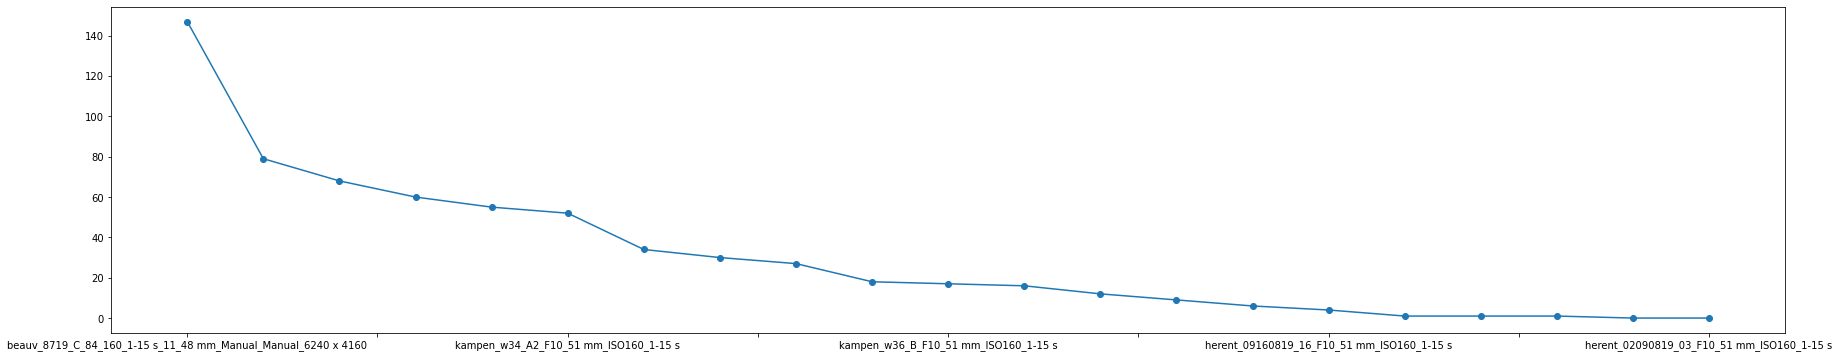

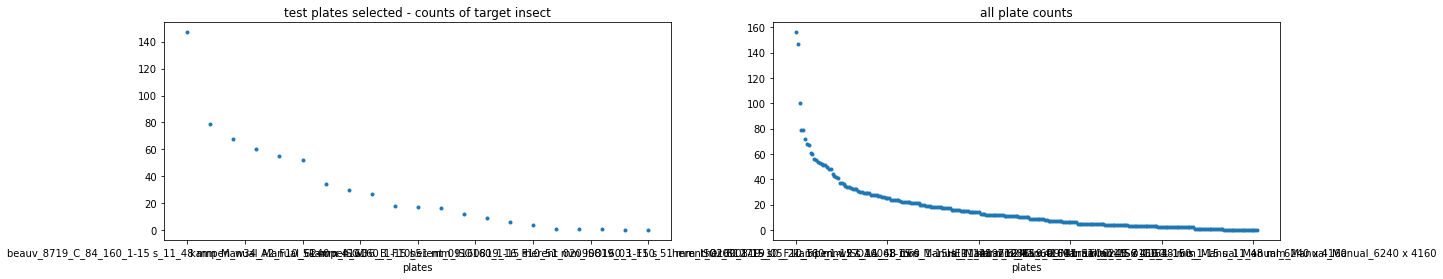

In [2]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_orig = pd.DataFrame()
df_orig['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/*.jpg"))
df_orig['pname'] = df_orig['x'].apply(lambda p: p.split('/')[-1][:-4])
df_orig['pname'] = df_orig['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_orig['y_text'] = df_orig['x'].apply(lambda x: x.split('/')[-2])
df_orig['y'] = le.fit_transform(df_orig.y_text)

target_insect_dict = {}
for i, sub in df_orig.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)
# Sampling some test plates. 2 from first 5, 2 from next five....
test_plates = []
test_plates.extend(ser.iloc[:5].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[5:10].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[10:15].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[20:].sample(15, random_state=42).index.values.tolist())
test_plates = ser.loc[test_plates].sort_values(ascending=False).index.tolist()

ser.plot(marker='o', figsize=(30,6))
plt.figure()
ser.loc[test_plates].sort_values(ascending=False).plot(marker='o', figsize=(30,6))

plt.figure(figsize=(20,4))
plt.subplot(121)
ser.loc[test_plates].plot(style='.'); plt.xlabel('plates');plt.title('test plates selected - counts of target insect')
print(f"nr of test plates: {ser.loc[test_plates].shape[0]}")
plt.subplot(122)
ser.plot(style='.'); plt.xlabel('plates'); plt.title('all plate counts')
print(f"nr of all plates: {ser.shape[0]}")

X_test = df_orig.x[df_orig.pname.isin(test_plates)]
y_test = df_orig.y[df_orig.pname.isin(test_plates)]

X_test, y_test = shuffle(X_test, y_test, random_state=seed)

In [3]:
print("Test set class balance")
print(df_orig[df_orig.pname.isin(test_plates) ].y_text.value_counts())

X_train = df_orig.x[~df_orig.pname.isin(test_plates)]
y_train = df_orig.y[~df_orig.pname.isin(test_plates)]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, shuffle=True)

Test set class balance
wmv      637
v        368
m        252
c        193
v(cy)    191
t        172
sw       159
bv       128
bl       106
Name: y_text, dtype: int64


In [4]:
# Splitting into train/val/test # Randomly
# X_train, X_test, y_train, y_test = train_test_split(df_orig.x, df_orig.y, test_size=0.2, random_state=seed, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

In [5]:
augment_trainset(X_train=X_train, y_train=y_train, 
                 aug_imgs_path=path_images_augmented,
                 img_dim=img_dim,
                 nb_batches= 200, 
                 batch_size=500)

 Reading image data and assigning labels...
Normalizing data by dividing by 255.
Creating an ImageDataGenerator.
Creating directories for each class.
Fitting data generator on data.
Expanding dataset by using generator's flow method on data/labels.
using batch_size of 500
Finished augmentation in 200 batches of 500


In [6]:
# Gathering info on augmented X_train data
df_aug = pd.DataFrame()
df_aug['x'] = pd.Series(glob.glob(f"{path_images_augmented}/*/*.jpg"))
df_aug['textlabels'] = df_aug['x'].apply(lambda x: x.split('/')[-2])
df_aug['y'] = le.fit_transform(df_aug.textlabels)

In [7]:
X_train_aug = df_aug.x.tolist()
y_train_aug = df_aug.y.tolist()

c = list(zip(X_train_aug, y_train_aug))
random.shuffle(c)
X_train_aug, y_train_aug = zip(*c)
X_train_aug = list(X_train_aug)
y_train_aug = list(y_train_aug)
X_val = X_val.tolist()
y_val = y_val.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

In [8]:
log_dir = f'{created_data_path}/logs/'
top_weights_path = f'{created_data_path}/weights/{modelname}.h5'

callbacks_list = [ModelCheckpoint(monitor =  monitor,
                                  filepath =  top_weights_path,
                                  save_best_only = False,
                                  save_weights_only = False,
                                  verbose = 1),
                  EarlyStopping(monitor =  monitor,
                                patience =  es_patience,
                                verbose = 1),
                  ReduceLROnPlateau(monitor =  monitor,
                                    factor = 0.1,
                                    patience =  rlr_patience,
                                    verbose = 1),
                # CSVLogger(filename =  logfile),
                  TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)]

## TRAINING FROM SCRATCH

In [9]:
base_model = DenseNet121(include_top=False, weights=None, 
                        input_shape=(img_dim,img_dim,3))
# EfficientNetB2
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(nb_classes, activation=None)(x)
predictions = Activation('softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_aug), y=y_train_aug)
class_weights = {i : weights[i] for i in range(nb_classes)}

def get_labelencoder_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})
    return res

print(get_labelencoder_mapping(le))
print(class_weights)

{'bl': 0, 'bv': 1, 'c': 2, 'm': 3, 'sw': 4, 't': 5, 'v': 6, 'v(cy)': 7, 'wmv': 8}
{0: 1.5187708565072302, 1: 2.0671839515518546, 2: 0.8344537815126051, 3: 0.6407954945441746, 4: 1.7272296015180266, 5: 1.175147928994083, 6: 0.5967874118996885, 7: 1.4589288099372246, 8: 0.7645947081058379}


In [12]:
import math
FH = model.fit(train_generator(X_train_aug, y_train_aug, batch_size=batch_size, nb_classes=nb_classes, img_dim=img_dim), 
                         validation_data=valid_generator(X_val, y_val, batch_size=batch_size, nb_classes=nb_classes, img_dim=img_dim), 
                         steps_per_epoch=int(math.ceil(float(len(X_train_aug)) / float(batch_size))), 
                         validation_steps=int(math.ceil(float(len(X_val))/float(batch_size))), 
                         epochs=epochs, 
                         verbose=1, 
                         callbacks=callbacks_list, 
                         shuffle=True,
              class_weight=class_weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3073 steps, validate for 111 steps
Epoch 1/100
3072/3073 [============================>.] - ETA: 0s - loss: 1.4287 - accuracy: 0.5005
Epoch 00001: saving model to /home/kalfasyan/data/images/sticky_plates/created_data/weights/DenseNet121_9classes_150.h5
3073/3073 [==============================] - 443s 144ms/step - loss: 1.4290 - accuracy: 0.5005 - val_loss: 1.8574 - val_accuracy: 0.4021
Epoch 2/100
3072/3073 [============================>.] - ETA: 0s - loss: 1.0976 - accuracy: 0.6267
Epoch 00002: saving model to /home/kalfasyan/data/images/sticky_plates/created_data/weights/DenseNet121_9classes_150.h5
3073/3073 [==============================] - 387s 126ms/step - loss: 1.0978 - accuracy: 0.6267 - val_loss: 1.5580 - val_accuracy: 0.4952
Epoch 3/100
3072/3073 [============================>.] - ETA: 0s - loss: 0.9471 - accuracy: 0.6815
Epoch 00003: saving model to /home/kalfasyan/data/images/sticky_plates/created_data/weights/De

In [13]:
len(X_train)

20077

## FINE TUNING

In [ ]:
# base_model = DenseNet121(include_top=False, weights='imagenet', 
#                          input_shape=(img_dim,img_dim,3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# predictions = Dense(6, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# #for i, layer in enumerate(base_model.layers):
# #   print(i, layer.name)

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # train the model on the new data for a few epochs
# import math
# FH = model.fit_generator(train_generator(X_train_aug, y_train, batch_size=batch_size, nb_classes=6, img_dim=img_dim),
#                          validation_data=valid_generator(X_val, y_val, batch_size=batch_size, nb_classes=6, img_dim=img_dim), 
#                          steps_per_epoch=int(math.ceil(float(len(X_train_aug)) / float(batch_size))),
#                          validation_steps=int(math.ceil(float(len(X_val))/float(batch_size))),
#                          epochs=epochs, 
#                          verbose=1, 
#                          callbacks=callbacks_list)

In [ ]:
# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:425]:
#    layer.trainable = False
# for layer in model.layers[425:]:
#    layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# from tensorflow.keras.optimizers import SGD
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# FH2 = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
#     validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
#     epochs=epochs, verbose=1, callbacks=callbacks_list)

## EXTRACTING FEATURES